In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import LogLocator, LogFormatter
from collections import OrderedDict

sns.set(style="whitegrid")

In [2]:
def simulate_algo(
    algo_name="Fisher",
    iters=100,
    num_init_pts=10,
    pool_sz=10,
    linearity="1.0",
    measErr=False,
):
    variances_df = None
    gains_df = None

    fn_type = "param_diff"
    col_name = "param_diffs"

    org_distr = pd.read_csv(
        f"../data/{algo_name}_param_diff_linearity{linearity}_s{num_init_pts}_b{1}_p{pool_sz}_n{1000}_i{iters}_c{2}_m{measErr}.csv"
    )

    org_distr[col_name] = org_distr[col_name].apply(
        lambda x: np.fromstring(
            x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
            sep=" ",
        )[
            1:
        ]  # only slope (beta1)
    )

    org_distr = org_distr.iloc[num_init_pts:]

    variances = []
    gains = []
    group_col = "Iteration"
    max_iter = max(org_distr["Iteration"].unique()) + 1

    grouped = org_distr.groupby([group_col])
    for name, group in grouped:
        diffs = group[col_name]
        algo_var = np.var(np.array(diffs), axis=0)
        variances.append(algo_var)

    return pd.DataFrame(variances)

In [3]:
def plot_param_sims_mult_poolsz(
    logscale=False,
    iters=100,
    linearity=1.0,
    measErr=False,
    axes=None,
    fig=None,
    xstepSz=5,
):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]
    poolszs = [10, 100, 1000]  #
    figsz = (15, 4) if len(poolszs) > 1 else (15, 10)
    ylabel = r"Variance ($\beta$-hat - $\beta$_true)"
    if axes is None:
        fig, axes = plt.subplots(1, len(poolszs), figsize=figsz)
    # if fig:
    #     fig.suptitle(
    #         f"Variance on Linear Regression Model (lower is better)\n",
    #         size=30,
    #     )

    chungus_df = pd.DataFrame()
    for poolsz in poolszs:
        for ax_indx, algo in enumerate(algos):
            print(f"ALGO: {algo}, Pool Sizes: {poolsz}")
            variances_df = simulate_algo(
                algo, iters=iters, pool_sz=poolsz, linearity=linearity, measErr=measErr
            )
            variances_df.rename(
                columns={0: "Variance Difference in Params"}, inplace=True
            )
            variances_df = variances_df.reset_index().rename(
                columns={"index": "Iteration"}
            )
            variances_df["Algorithm"] = algo if algo != "Fisher" else "Our Approach"
            variances_df["Pool Size"] = poolsz
            chungus_df = pd.concat([chungus_df, variances_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df["Iteration"] += 10

    i = 0
    for ax, pool_sz in zip(axes, poolszs):
        data = chungus_df[chungus_df["Pool Size"] == pool_sz]
        ax.set_title(f"Pool Size = {pool_sz}", size=20)
        axplt = sns.lineplot(
            ax=ax,
            data=data,
            x="Iteration",
            y="Variance Difference in Params",
            marker="o",
            lw=3,
            hue="Algorithm",
        )
        axplt.set_xscale("log")
        axplt.set_yscale("log")
        axplt.set_xlabel("Labeled Sample Size", size=20)
        axplt.set_ylabel(ylabel, size=20)
        # Add custom gridlines at specific y-values (5, 10, 15, 20, 25, 30)
        xvalues = np.arange(10, np.max(data.Iteration) + xstepSz, xstepSz)
        for x in xvalues:
            ax.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
        for y in [1e-1]:
            ax.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

        # Set xticks at the specific x-values (logarithmic values)
        ax.xaxis.set_major_formatter(plt.ScalarFormatter())
        ax.xaxis.set_major_locator(
            LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 1.0), numticks=len(xvalues))
        )
        ax.set_xticks(xvalues)
        ax.xaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_xticklabels([str(x) for x in xvalues])
        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)

        if i:
            ax.get_legend().remove()
            axplt.set_ylabel("")
        i += 1

    # Collect all the handles and labels from the subplots
    # handles, labels = [], []
    # for ax in axes:
    #     for handle, label in zip(*ax.get_legend_handles_labels()):
    #         if label not in labels:  # Add only unique labels
    #             handles.append(handle)
    #             labels.append(label)

    # Add a single legend below the plots, increase font size
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=30)

    # Add black border to each subplot
    for ax in axes.flat:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")
    # Apply tight layout to adjust spacing
    plt.tight_layout()

    # Save the figure as a PDF
    path = f"../plots/linreg_i{iters}_l{round(float(linearity)*100)}_m{measErr}"
    plt.savefig(f"{path}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{path}.png", bbox_inches="tight")

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Variance Difference in Params,Algorithm,Pool Size


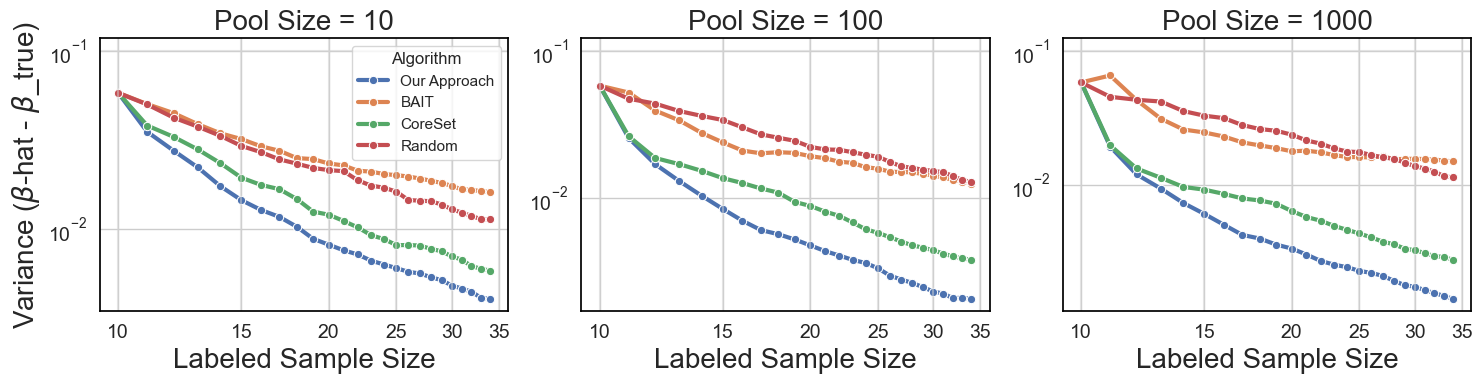

In [4]:
plot_param_sims_mult_poolsz(logscale=True, iters=25, linearity="1.0", measErr=False)

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Variance Difference in Params,Algorithm,Pool Size


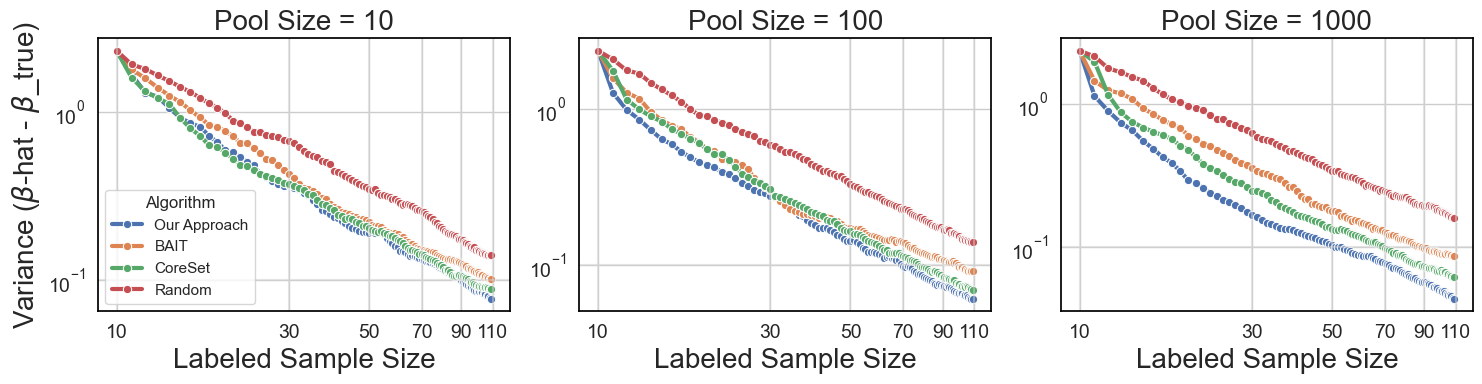

In [40]:
plot_param_sims_mult_poolsz(
    logscale=True, iters=100, linearity="1.0", measErr=True, xstepSz=20
)

In [6]:
def nonlinear_exp(
    axes, logscale=False, poolsz=100, iters=100, linearity=1.0, measErr=False
):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]  #
    # ylabel = r"Variance ($\beta$-hat - $\beta$_true)"

    chungus_df = pd.DataFrame()
    for ax_indx, algo in enumerate(algos):
        print(f"ALGO: {algo}, Pool Sizes: {poolsz}")
        variances_df = simulate_algo(
            algo, iters=iters, pool_sz=poolsz, linearity=linearity, measErr=measErr
        )
        variances_df.rename(columns={0: "Variance Difference in Params"}, inplace=True)
        variances_df = variances_df.reset_index().rename(columns={"index": "Iteration"})
        variances_df["Algorithm"] = algo if algo != "Fisher" else "Our Approach"
        variances_df["Pool Size"] = poolsz
        chungus_df = pd.concat([chungus_df, variances_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df["Iteration"] += 10

    data = chungus_df[chungus_df["Pool Size"] == poolsz]
    xstepSz = 20
    axplt = sns.lineplot(
        ax=axes,
        data=data,
        x="Iteration",
        y="Variance Difference in Params",
        marker="o",
        lw=3,
        hue="Algorithm",
    )
    axplt.set_xscale("log")
    axplt.set_yscale("log")
    axplt.set_ylabel("")
    axplt.set_xlabel("Labeled Sample Size", size=20)
    xvalues = np.arange(10, np.max(data.Iteration) + xstepSz, xstepSz)
    for x in xvalues:
        axplt.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
    for y in [1e-1]:
        axplt.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

    # Set xticks at the specific x-values (logarithmic values)
    axplt.xaxis.set_major_formatter(plt.ScalarFormatter())
    # axplt.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 1.0), numticks=len(xvalues)))
    # axplt.set_xticks(xvalues)
    axplt.xaxis.set_major_formatter(LogFormatter(base=10.0))
    # axplt.set_xticklabels([str(x) for x in xvalues])
    axplt.tick_params(axis="x", labelsize=10)
    axplt.tick_params(axis="y", labelsize=10)

    line1 = (
        data[data["Algorithm"] == "BAIT"]
        if float(linearity) < 1.0
        else data[data["Algorithm"] == "CoreSet"]
    )
    line2 = data[data["Algorithm"] == "Our Approach"]

    # Calculate where the two lines intersect (find the closest y-values)
    x_vals = line1["Iteration"].values[1:]
    y1_vals = line1["Variance Difference in Params"].values[1:]
    y2_vals = line2["Variance Difference in Params"].values[1:]
    diff = np.abs(y1_vals - y2_vals)
    intersection_index = np.argmin(diff)

    # Get intersection coordinates
    intersection_x = x_vals[intersection_index]
    intersection_y = y1_vals[intersection_index]
    # Add a vertical line at the intersection point
    axplt.axvline(x=intersection_x, color="black", linestyle="--")

    # Optionally, add a label or annotation at the intersection
    axes.set_title(
        r"$\lambda$ = "
        + f"{linearity}\n[Number of Additional Points: {intersection_x - 10}]\n",
        size=20,
    )

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100


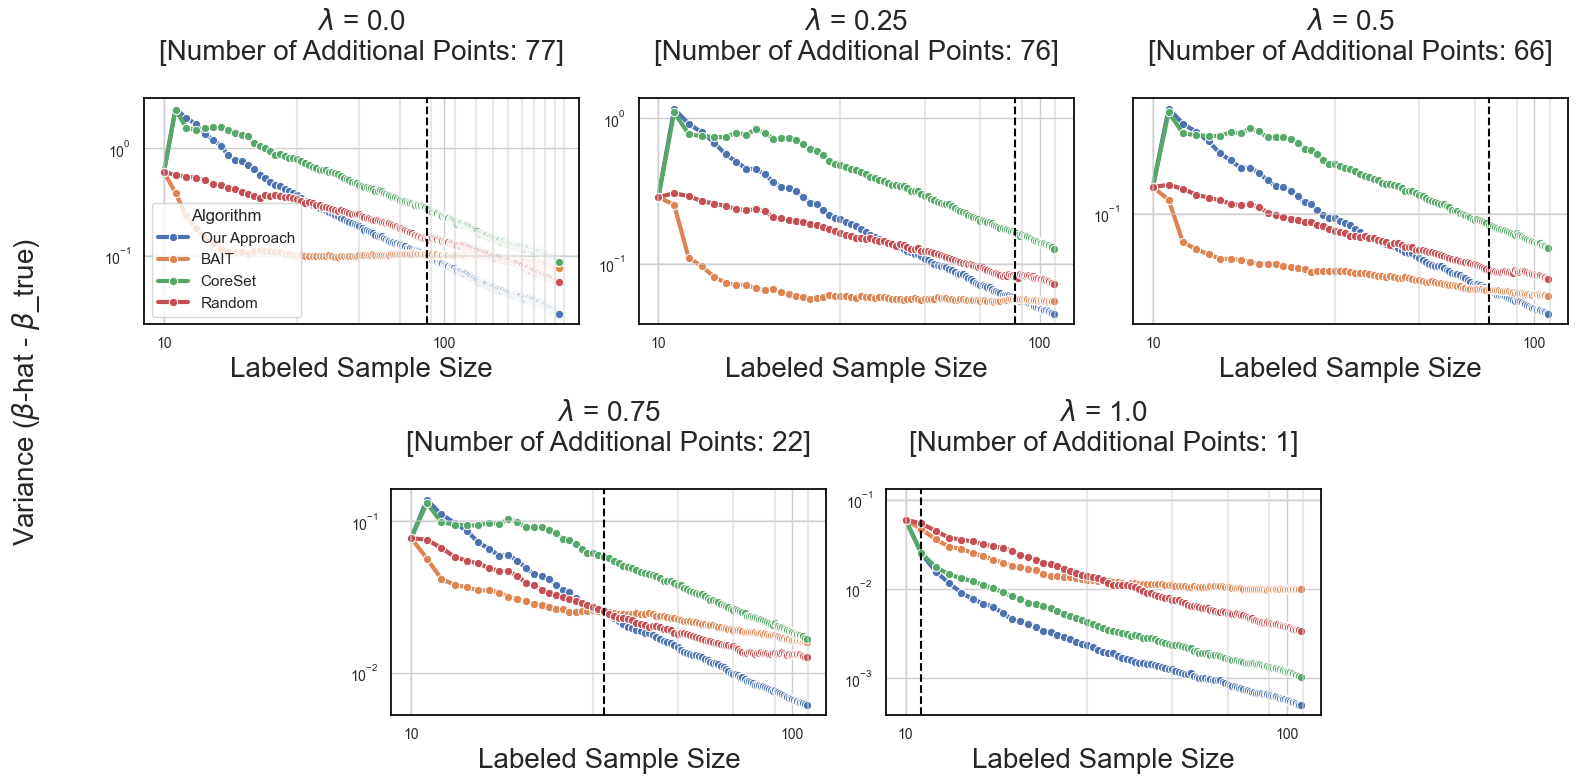

In [7]:
def plot_all_nonlin_exp():
    # Create a figure with a 5x1 grid of subplots (5 rows, 1 column)
    # spec = mpl.gridspec.GridSpec(ncols=6, nrows=2)
    # fig, axs = plt.subplots(2, 3)  # Adjust figsize as needed , figsize=(30, 5)
    fig = plt.figure(figsize=(15, 8))
    spec = mpl.gridspec.GridSpec(
        ncols=6, nrows=2
    )  # 6 columns evenly divides both 2 & 3
    # fig.sup_ylabel(r"Variance ($\beta$-hat - $\beta$_true)")
    fig.text(
        -0.04,
        0.5,
        r"Variance ($\beta$-hat - $\beta$_true)",
        va="center",
        ha="center",
        rotation="vertical",
        fontsize=20,
    )

    ax1 = fig.add_subplot(spec[0, 0:2])  # row 0 with axes spanning 2 cols on evens
    ax2 = fig.add_subplot(spec[0, 2:4])
    ax3 = fig.add_subplot(spec[0, 4:])
    ax4 = fig.add_subplot(spec[1, 1:3])  # row 0 with axes spanning 2 cols on odds
    ax5 = fig.add_subplot(spec[1, 3:5])

    # Call plot_param_sims for each set of parameters and assign to different subplots
    nonlinear_exp(logscale=True, iters=250, linearity="0.0", measErr=False, axes=ax1)
    nonlinear_exp(logscale=True, iters=100, linearity=0.25, measErr=False, axes=ax2)
    nonlinear_exp(logscale=True, iters=100, linearity=0.5, measErr=False, axes=ax3)
    nonlinear_exp(logscale=True, iters=100, linearity=0.75, measErr=False, axes=ax4)
    nonlinear_exp(logscale=True, iters=100, linearity=1.0, measErr=False, axes=ax5)

    for ax in [ax2, ax3, ax4, ax5]:
        ax.get_legend().remove()

    # Add black border to each subplot
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")

    # Adjust the layout to avoid overlap
    # Apply tight layout to adjust spacing
    plt.tight_layout()

    # Save the figure as a PDF
    plt.savefig("../plots/nonlinear.pdf", format="pdf", bbox_inches="tight")
    plt.savefig("../plots/nonlinear.png", bbox_inches="tight")
    plt.show()


plot_all_nonlin_exp()

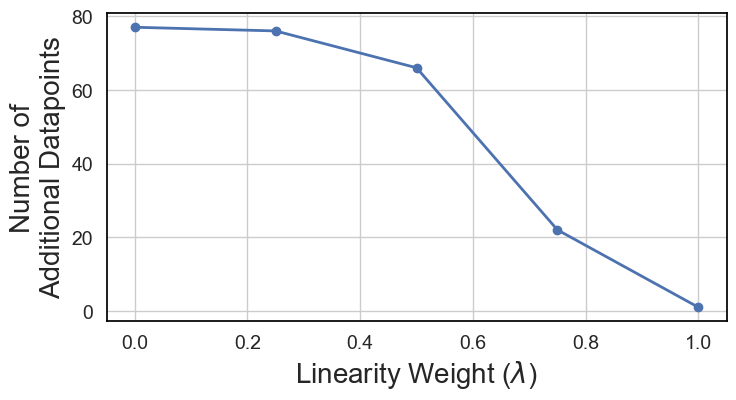

In [8]:
x = [0, 0.25, 0.5, 0.75, 1.0]
y = np.array([87, 86, 76, 32, 11])  # number of datapoints (including initial_sz = 10)
y -= 10
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # Adjust figsize as needed
plt.plot(x, y, linewidth=2, marker="o")
plt.xlabel(r"Linearity Weight ($\lambda$)", size=20)
plt.ylabel("Number of\nAdditional Datapoints", size=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
# plt.title(r"Number of Additional Datapoints Until Our Approach is Optimal vs $\lambda$" + "\n(Lower is Better)\nInitial Number of Points = 10; Pool Size=100")
# for i in range(len(x)):
#     plt.text(x[i] + 0.01, y[i] + 0.01, f'({x[i]}, {y[i]})', fontsize=10, bbox=dict(facecolor='lightblue', boxstyle='round,pad=0.3'))

ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

# Save the figure as a PDF
plt.savefig("../plots/nonlinear_iters.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../plots/nonlinear_iters.png", bbox_inches="tight")
plt.show()

In [9]:
def plot_gain_ratios(ax, pool_sz, iters=500, measErr=False, xstepSz=125):
    df = pd.read_csv(
        f"../data/variancesDf_linearity1.0_s10_b1_p{pool_sz}_n1_i{iters}_c2_m{measErr}.csv"
    )
    df["Iteration"] += 10
    df["Gain Ratio"] = df.apply(
        lambda row: row["Var(Labeled Points)"]
        / (
            df.loc[(df["Algorithm"] == "Random") & (df["Iteration"] == row.Iteration)]
            .reset_index(drop=True)
            .iloc[0]["Var(Labeled Points)"]
        ),
        axis=1,
    )
    max_iters = max(df["Iteration"])
    for algo in df["Algorithm"].unique():
        mini_df = df[df.Algorithm == algo]
        max_gain = mini_df["Gain Ratio"].max()
        print(f"{algo} PoolSz: {pool_sz} -- Max GR = {max_gain:.2f}")

    axplt = sns.lineplot(
        data=df, x="Iteration", y="Gain Ratio", hue="Algorithm", lw=3, ax=ax
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Labeled Sample Size", size=20)
    ax.set_ylabel(r"$\frac{Var(\widetilde{X}_{algo})}{Var(X_{random})}$", size=20)
    ax.set_title(f"Pool Size = {pool_sz}", size=20)
    # Add custom gridlines at specific y-values (5, 10, 15, 20, 25, 30)
    xvalues = np.arange(10, np.max(df.Iteration) + xstepSz, xstepSz)
    yvalues = np.arange(1, np.max(df["Gain Ratio"]) + 1, 1)
    for x in xvalues:
        ax.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
    for y in yvalues:
        ax.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

    # Set xticks at the specific x-values (logarithmic values)
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.set_major_locator(
        LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 1.0), numticks=len(xvalues))
    )
    ax.set_xticks(xvalues)
    ax.xaxis.set_major_formatter(LogFormatter(base=10.0))
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())
    ax.yaxis.set_major_locator(
        LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 1.0), numticks=len(yvalues))
    )
    ax.set_yticks(yvalues)
    ax.yaxis.set_major_formatter(LogFormatter(base=10.0))
    ax.set_xticklabels([str(x) for x in xvalues])
    ax.set_yticklabels([str(y) for y in yvalues])
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)


def plot_gain_ratios_mult_poolSz(iters=500, measErr=False):
    poolszs = [10, 100, 1000]
    fig, axes = plt.subplots(1, len(poolszs), figsize=(15, 4), sharey=True)
    # fig.suptitle(r"Comparison of Sampling Algorithms' Gain Ratios $\left(\frac{Var(\widetilde{X}_{algo})}{Var(X_{random})}\right)$"+f"\n(Higher is Better)\n[Initial Number of Points = 10, {'' if measErr else 'No'} Measurement Error]", size=20)
    i = 0
    for ax, pool_sz in zip(axes, poolszs):
        plot_gain_ratios(ax, pool_sz, iters, measErr)
        if i:
            ax.get_legend().remove()
        i += 1

    # # Collect all the handles and labels from the subplots
    # handles, labels = [], []
    # for ax in axes:
    #     for handle, label in zip(*ax.get_legend_handles_labels()):
    #         if label not in labels:  # Add only unique labels
    #             handles.append(handle)
    #             labels.append(label)

    # # Add a single legend below the plots, increase font size
    # fig.legend(handles=handles, labels=labels,
    #            loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=20)
    # Add black border to each subplot
    for ax in axes.flat:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")
    plt.tight_layout()
    plt.savefig(f"../plots/gain_plot_m{measErr}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"../plots/gain_plot_m{measErr}.pdf", bbox_inches="tight")
    plt.show()

Our Approach PoolSz: 10 -- Max GR = 3.23
BAIT PoolSz: 10 -- Max GR = 1.58
CoreSet PoolSz: 10 -- Max GR = 2.02
Random PoolSz: 10 -- Max GR = 1.00
Our Approach PoolSz: 100 -- Max GR = 7.02
BAIT PoolSz: 100 -- Max GR = 2.35
CoreSet PoolSz: 100 -- Max GR = 3.69
Random PoolSz: 100 -- Max GR = 1.00
Our Approach PoolSz: 1000 -- Max GR = 10.71
BAIT PoolSz: 1000 -- Max GR = 3.58
CoreSet PoolSz: 1000 -- Max GR = 5.30
Random PoolSz: 1000 -- Max GR = 1.00


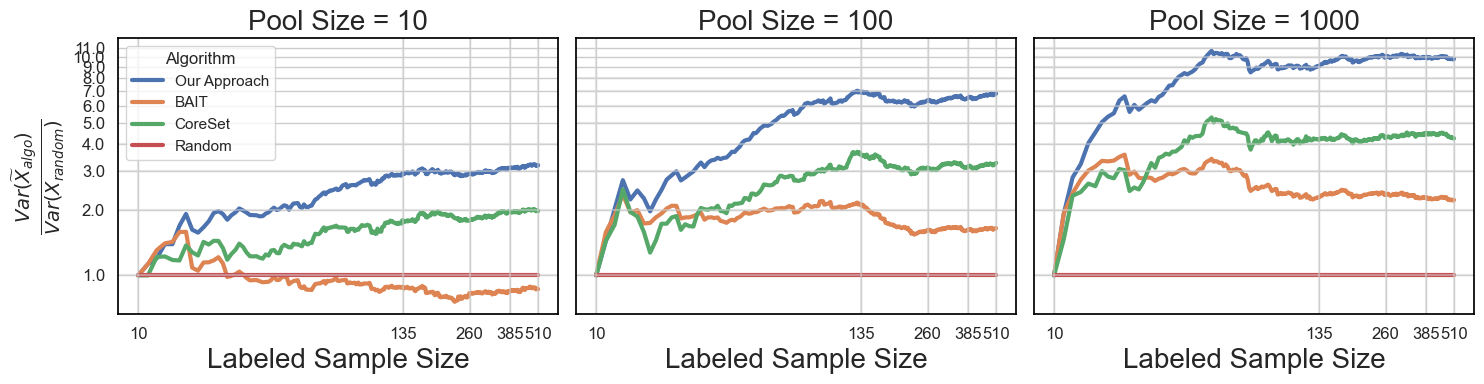

In [10]:
plot_gain_ratios_mult_poolSz()

Our Approach PoolSz: 10 -- Max GR = 2.14
BAIT PoolSz: 10 -- Max GR = 1.82
CoreSet PoolSz: 10 -- Max GR = 2.02
Random PoolSz: 10 -- Max GR = 1.00
Our Approach PoolSz: 100 -- Max GR = 3.55
BAIT PoolSz: 100 -- Max GR = 3.01
CoreSet PoolSz: 100 -- Max GR = 3.69
Random PoolSz: 100 -- Max GR = 1.00
Our Approach PoolSz: 1000 -- Max GR = 2.43
BAIT PoolSz: 1000 -- Max GR = 1.57
CoreSet PoolSz: 1000 -- Max GR = 5.30
Random PoolSz: 1000 -- Max GR = 1.00


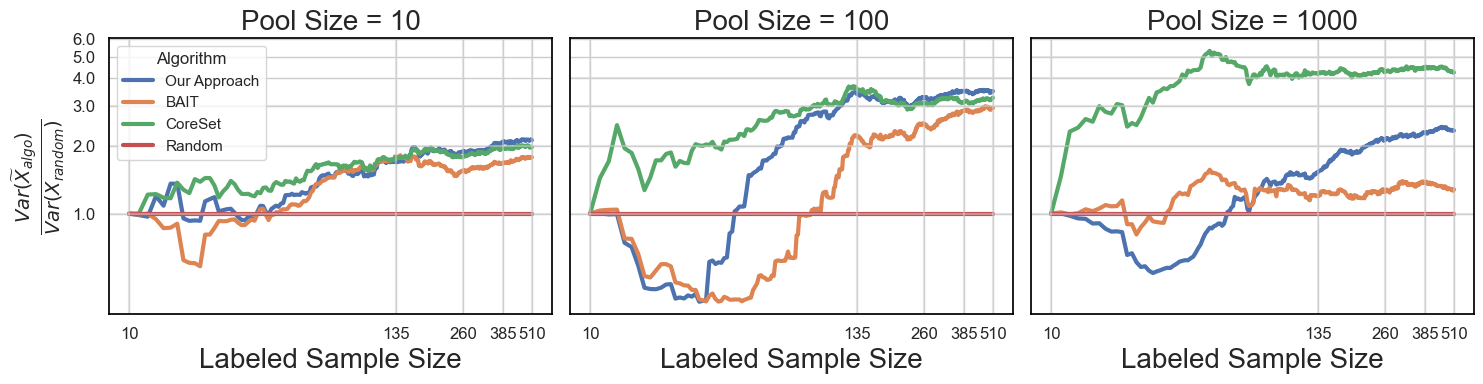

In [11]:
plot_gain_ratios_mult_poolSz(measErr=True)

In [12]:
def gain_ratio_exact(
    logscale=False,
    iters=100,
    linearity=1.0,
    measErr=False,
    axes=None,
    fig=None,
    xstepSz=5,
):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]
    poolszs = [10, 100, 1000]  #
    figsz = (15, 5) if len(poolszs) > 1 else (15, 10)
    ylabel = r"Gain Ratio"
    if axes is None:
        fig, axes = plt.subplots(1, len(poolszs), figsize=figsz, sharey=True)

    chungus_df = pd.DataFrame()
    for poolsz in poolszs:
        for ax_indx, algo in enumerate(algos):
            print(f"ALGO: {algo}, Pool Sizes: {poolsz}")
            variances_df = simulate_algo(
                algo, iters=iters, pool_sz=poolsz, linearity=linearity, measErr=measErr
            )
            variances_df.rename(
                columns={0: "Variance Difference in Params"}, inplace=True
            )
            variances_df = variances_df.reset_index().rename(
                columns={"index": "Iteration"}
            )
            variances_df["Algorithm"] = algo if algo != "Fisher" else "Our Approach"
            variances_df["Pool Size"] = poolsz
            chungus_df = pd.concat([chungus_df, variances_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df["Iteration"] += 10

    i = 0
    for ax, pool_sz in zip(axes, poolszs):
        data = chungus_df[chungus_df["Pool Size"] == pool_sz].copy()
        data["Gain Ratio"] = data.apply(
            lambda row: (
                data.loc[
                    (data["Algorithm"] == "Random")
                    & (data["Iteration"] == row.Iteration)
                ]
                .reset_index(drop=True)
                .iloc[0]["Variance Difference in Params"]
                / row["Variance Difference in Params"]
            ),
            axis=1,
        )

        ax.set_title(f"Pool Size = {pool_sz}", size=20)
        axplt = sns.lineplot(
            ax=ax,
            data=data,
            x="Iteration",
            y="Gain Ratio",
            marker="o",
            lw=3,
            hue="Algorithm",
        )
        axplt.set_xscale("log")
        axplt.set_yscale("log")
        axplt.set_xlabel("Labeled Sample Size", size=20)
        axplt.set_ylabel(ylabel, size=20)

        # Add custom gridlines at specific y-values (5, 10, 15, 20, 25, 30)
        xvalues = np.arange(10, np.max(data.Iteration) + xstepSz, xstepSz)
        yvalues = np.arange(1, np.max(data["Gain Ratio"]) + 1, 1)
        for x in xvalues:
            ax.axvline(x=x, color="lightgrey", linestyle="-", alpha=0.5)
        for y in yvalues:
            ax.axhline(y=y, color="lightgrey", linestyle="-", alpha=0.5)

        # Set xticks at the specific x-values (logarithmic values)
        ax.set_xticks(xvalues)
        ax.xaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_xticklabels([str(x) for x in xvalues])
        ax.set_yticks(yvalues)
        ax.yaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.set_yticklabels([str(y) for y in yvalues])
        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)

        if i:
            ax.get_legend().remove()
            axplt.set_ylabel("")
        i += 1

    # Add black border to each subplot
    for ax in axes.flat:
        ax.spines["top"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")

    # Apply tight layout to adjust spacing
    plt.tight_layout()

    # Save the figure as a PDF
    path = f"../plots/exact_gain_i{iters}_l{round(float(linearity)*100)}_m{measErr}"
    plt.savefig(f"{path}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{path}.png", bbox_inches="tight")

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000
ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Variance Difference in Params,Algorithm,Pool Size


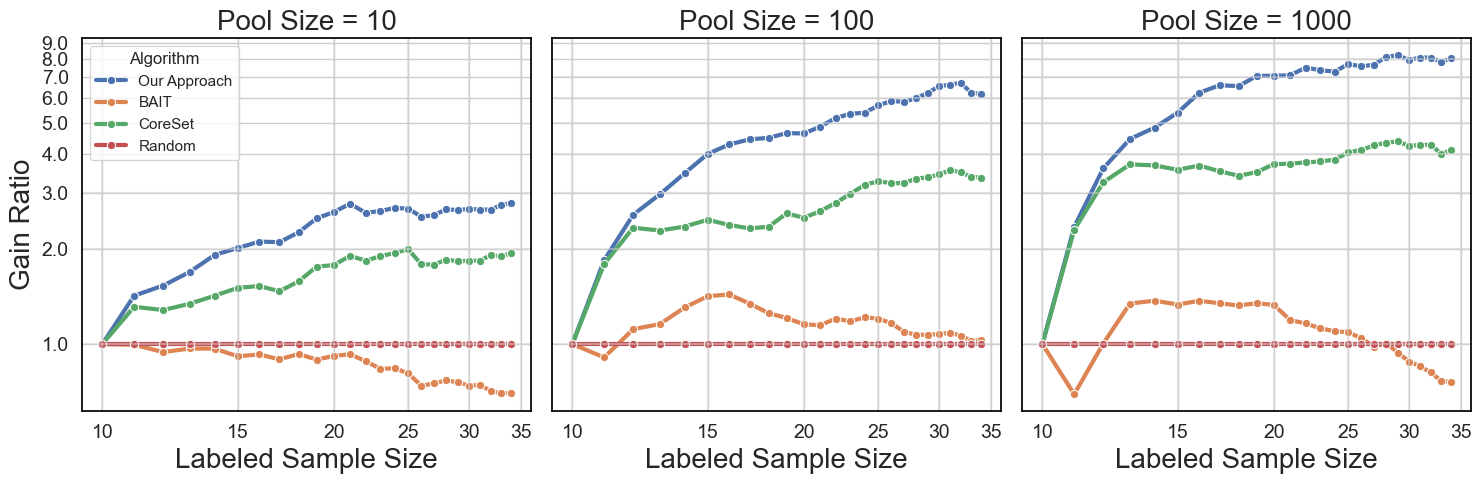

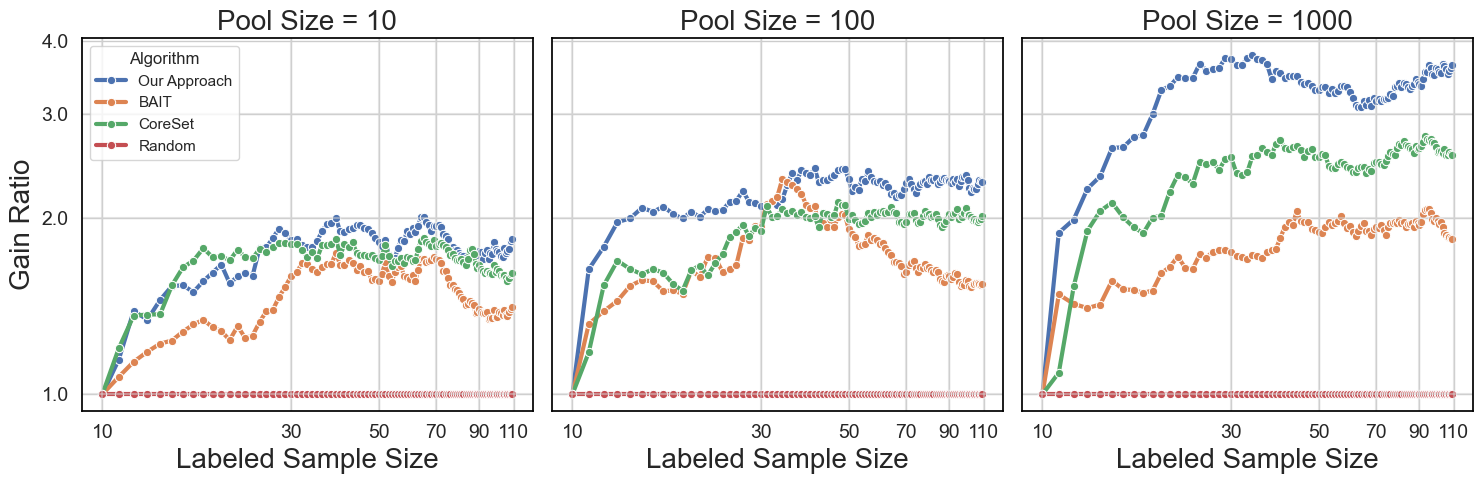

In [41]:
gain_ratio_exact(logscale=True, iters=25, linearity="1.0", measErr=False)
gain_ratio_exact(logscale=True, iters=100, linearity="1.0", measErr=True, xstepSz=20)

In [107]:
df = pd.read_csv("../data/multiVar_linearity1.0_s10_b1_p100_n1_i1000_c5_mFalse.csv")
df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
df["Algorithm"] = df["Algorithm"].replace(
    {
        "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
        "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
    }
)
df = df.sort_values(by="Algorithm", ascending=True)
df

,Iteration,X1,X2,Algorithm
0,0,-1.519431,0.863977,Our Approach (Pool Size = 100)
665,665,-2.791266,-0.324396,Our Approach (Pool Size = 100)
666,666,3.013479,-0.725840,Our Approach (Pool Size = 100)
667,667,1.028220,-3.953838,Our Approach (Pool Size = 100)
668,668,2.784718,-1.209876,Our Approach (Pool Size = 100)
...,...,...,...,...
11675,666,-0.334989,1.731131,Random
11674,665,-1.202948,-2.047193,Random
11673,664,0.794383,-1.064296,Random
11686,677,-0.840968,-0.364743,Random


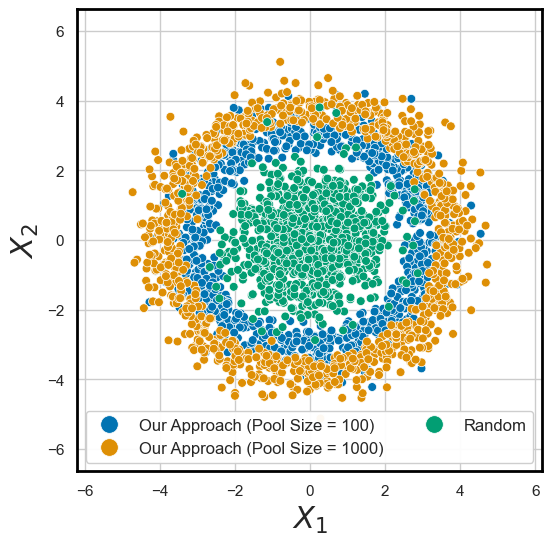

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))

# Scatterplot with hue
sns.scatterplot(
    data=df.iloc[10:], x="X1", y="X2", hue="Algorithm", s=40, palette="colorblind"
)

# Add legend with background color
plt.legend(
    loc=3,
    borderaxespad=0.5,
    markerscale=2,
    fancybox=True,
    framealpha=0.95,
    ncols=2,
    facecolor="white",
    prop={"size": 12},
)

# Add labels
plt.xlabel(r"$X_1$", size=22)
plt.ylabel(r"$X_2$", size=22)

# Increase x and y limits by 1 unit on both sides
x_min, x_max = plt.xlim()  # Get current x limits
y_min, y_max = plt.ylim()  # Get current y limits
plt.xlim(x_min - 1, x_max + 1)  # Increase x limits by 1 unit on both sides
plt.ylim(y_min - 1, y_max + 1)  # Increase y limits by 1 unit on both sides

# Add a black border around the plot area (the axes)
for spine in ax.spines.values():
    spine.set_edgecolor("black")  # Set the border color
    spine.set_linewidth(2)  # Set the border width

# Save the plot as an image file
plt.savefig("../plots/multivar-labeledX-chi2.pdf", bbox_inches="tight")

/var/folders/fl/ys5j0k6970z5_f6t206h5pxr0000gp/T/ipykernel_20590/1774294411.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(borderaxespad=0.5, markerscale=2, fancybox=True, framealpha=0.95, facecolor='white', prop={'size':10})


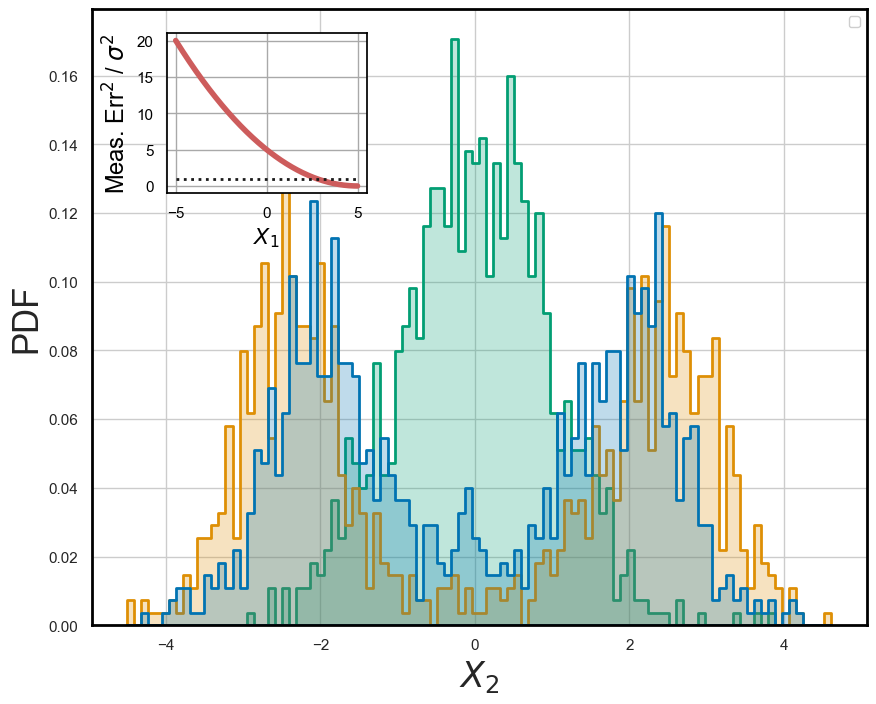

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))
df = pd.read_csv("../data/multiVar_linearity1.0_s10_b1_p100_n1_i1000_c5_mTrue.csv")
df = df[df.Algorithm != "Our Approach (Pool Size = 100, Budget = 10)"]
df["Algorithm"] = df["Algorithm"].replace(
    {
        "Our Approach (Pool Size = 100, Budget = 1)": "Our Approach (Pool Size = 100)",
        "Our Approach (Pool Size = 1000, Budget = 1)": "Our Approach (Pool Size = 1000)",
    }
)
df = df.sort_values(by="Algorithm", ascending=True)

sns.histplot(
    data=df.iloc[10:],
    x="X2",
    hue="Algorithm",
    bins=100,
    kde=False,
    element="step",
    stat="density",
    linewidth=2,
    palette="colorblind",
)

plt.legend(
    borderaxespad=0.5,
    markerscale=2,
    fancybox=True,
    framealpha=0.95,
    facecolor="white",
    prop={"size": 10},
)

plt.xlabel(r"$X_2$", size=25)
plt.ylabel(r"PDF", size=25)

# Define the position and size of the embedded plot
left, bottom, width, height = 0.2, 0.65, 0.2, 0.2
ax2 = fig.add_axes([left, bottom, width, height])

xlin = np.linspace(-5, 5, 1001)
ax2.plot(xlin, 5.0 * (xlin - 5.0) ** 2 / 25.0, lw=4, color="indianred")
ax2.plot(xlin, xlin * 0 + 1.0, ":", lw=2, color="k")

# Set the background color and axis color of ax2
ax2.set_facecolor("white")
ax2.spines["bottom"].set_color("black")
ax2.spines["top"].set_color("black")
ax2.spines["left"].set_color("black")
ax2.spines["right"].set_color("black")
ax2.xaxis.label.set_color("black")
ax2.yaxis.label.set_color("black")
ax2.tick_params(axis="x", colors="black")
ax2.tick_params(axis="y", colors="black")
ax2.grid(True, color="darkgrey")

ax2.set_xlabel(r"$X_1$", size=16)
ax2.set_ylabel(r"Meas. Err$^2$ / $\sigma^2$", size=17)


# Add a black border around the plot area (the axes)
for spine in ax.spines.values():
    spine.set_edgecolor("black")  # Set the border color
    spine.set_linewidth(2)  # Set the border width

# Save the plot as an image file
# plt.savefig('sampling_test_2.png', bbox_inches='tight')
# files.download('sampling_test_2.png')
plt.savefig("../plots/multivar-labeledX-chi2-measErr.pdf", bbox_inches="tight")

Text(0, 0.5, '$X_2$')

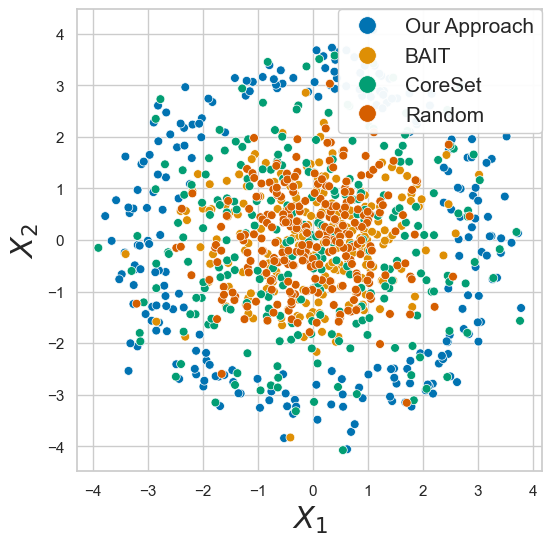

In [98]:
df = pd.read_csv("../data/multiVar_linearity1.0_s10_b1_p100_n1_i250_c5_mFalse.csv")
fig = plt.figure(figsize=(6, 6))

ours = df[df.Algorithm == "Our Approach"]
random = df[df.Algorithm == "Random"]
# plt.plot(ours['X1'][10:], ours['X2'][10:], markersize=4, color='steelblue', label='Pool size = 100')
# plt.plot(random['X1'][10:], random['X2'][10:], markersize=4, color='red', label='Random')
sns.scatterplot(
    data=df, x="X1", y="X2", hue="Algorithm", s=40, palette="colorblind"
)  # ,, palette={'Our Approach': 'navy', 'Random': 'red'}

# Add legend with background color
plt.legend(
    loc=1,
    borderaxespad=0.0,
    markerscale=2,
    fancybox=True,
    framealpha=0.95,
    facecolor="white",
    prop={"size": 15},
)

plt.xlabel(r"$X_1$", size=22)
plt.ylabel(r"$X_2$", size=22)

# Save the plot as an image file
# plt.savefig('test_1.png', bbox_inches='tight')
# files.download('test_1.png')